In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import sqlite3
import pandas as pd
from src import clean_data
conn = sqlite3.connect('data/billboard-200.db')

In [2]:
albums_table = pd.read_sql_query('select * from albums', conn)[1:]
albums_table['rank'] = pd.to_numeric(albums_table['rank'], downcast='signed')
albums_table['power'] = 1 / albums_table['rank']
albums_table['date'] = pd.to_datetime(albums_table['date'])

In [3]:
albums, artists, songs = clean_data.get()

In [4]:
song_parameters = ['tempo',
                   'valence',
                   'danceability', 
                   'energy',
                   'liveness', 
                   'loudness', 
                   'acousticness', 
                   'instrumentalness',
                   'speechiness']

In [5]:
albums[song_parameters] = (songs.join(albums, on=['album', 'artist'])
                                .groupby(['album', 'artist'])
                                .mean()
                          )[song_parameters]

In [6]:
def weighted_score(param, chart):
    power_rank_col = chart['power']
    param_col = chart[param]
    return (power_rank_col * param_col).sum() / power_rank_col.sum()

In [7]:
weekly_charts = albums_table.merge(albums, 
                                   on=['album','artist'], 
                                   how='left'
                                  ).groupby('date')
week_scores = []
week_dates = []
for date, chart in weekly_charts:
        params = {p:0 for p in song_parameters}
        for p in params:
            params[p] = weighted_score(p, chart)
            
        week_scores.append(params)
        week_dates.append(date)
        
# Timeseries containing the scores for every week
parameter_ts = pd.DataFrame(week_scores, index=week_dates)

In [18]:
resampled = parameter_ts.resample(pd.Timedelta(1200,'day')).mean()

In [19]:
normal_parameters = ['valence',
                   'danceability', 
                   'energy',
                   'liveness', 
                   'acousticness', 
                   'instrumentalness',
                   'speechiness']

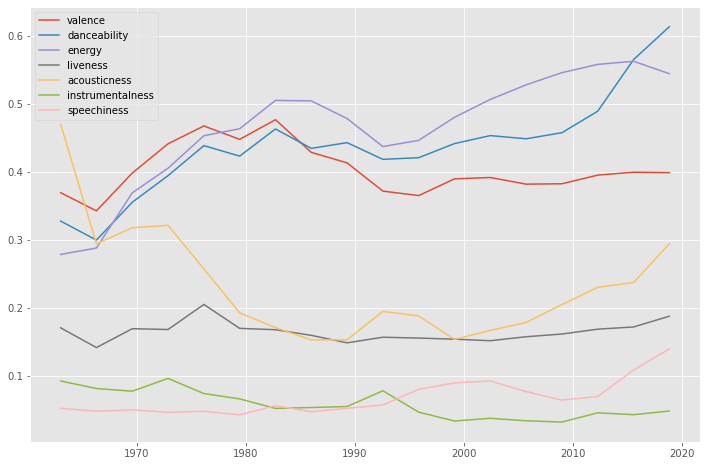

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
for p in normal_parameters:
    ax.plot(resampled.index, resampled[p])
    
ax.legend(normal_parameters);